# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


In [1]:
student1_id = '327156998'
student2_id = '123456789'

**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [2]:
# %pip install --q
# %pip install --q transformers
# %pip install -U sentence-transformers

All imports: (You may add/change)

In [3]:
# general
import os
import random
import warnings
from typing import List,Tuple
import pickle


# ML
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoModel
from sentence_transformers import SentenceTransformer


Set warnings filter to ignore:

In [4]:
# set warnings filter to ignore:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [5]:
# set random SEEDs:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Set GPU:

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'
print(f'Using {DEVICE} device')

Using cuda device


## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [7]:
# !git clone https://github.com/kfirbar/nlp-course

## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [8]:
import re
from typing import List, Tuple

def read_data(filepath: str, remove_e1_e2_from_label: bool = True) -> List[Tuple[str, str]]:
    data = []
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 4): # 4 lines per sample
            sentence = re.findall(r'"([^"]*)"', lines[i])[0]
            label = lines[i+1].strip()
            # remove (e1,e2) from label
            if remove_e1_e2_from_label:
                label = label.replace('(e1,e2)', '').replace('(e2,e1)', '').strip()
            data.append((sentence, label))
    return data

# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"
# Read the data (tuple of (sentence, label)
train = read_data(train_filepath)
test = read_data(test_filepath)
# Convert to pandas dataframe
train_df = pd.DataFrame(train, columns=['sentence', 'label'])
test_df = pd.DataFrame(test, columns=['sentence', 'label'])

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))


Number of train sentences: 8000
Number of test sentences: 2717


In [9]:
# print some examples
print('Train examples:')
display(train_df.sample(5))
print('Test examples:')
display(test_df.sample(5))


Train examples:


,sentence,label
879,"In the evening, he threw <e1>wood</e1> into th...",Entity-Destination
5183,"Furthermore, the present invention includes a ...",Other
3143,The device is the best solution for <e1>headph...,Component-Whole
2967,The candle <e1>wax</e1> is the main ingredient...,Entity-Origin
2,The <e1>author</e1> of a keygen uses a <e2>dis...,Instrument-Agency


Test examples:


,sentence,label
1740,The fleeing <e1>convicts</e1> were picked out ...,Other
1333,Another great sign was the wonderful aroma of ...,Content-Container
2196,"Nonetheless, people in the <e1>film</e1> <e2>i...",Product-Producer
744,Many <e1>problems</e1> have ensued from the ne...,Cause-Effect
2602,"Sometime shortly before the murder, a woman ca...",Other


`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [10]:
def create_label_mapper(data):
  # create a dictionary that maps each id to a label
  id2label = {}
  label2id = {}
  unique_labels = data['label'].unique()
  for i, label in enumerate(unique_labels):
    id2label[i] = label
    label2id[label] = i
  return id2label, label2id



# TO DO
id2label, label2id = create_label_mapper(train_df)

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

id2label: 
 {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

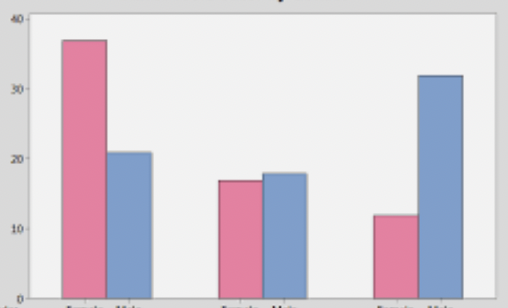

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

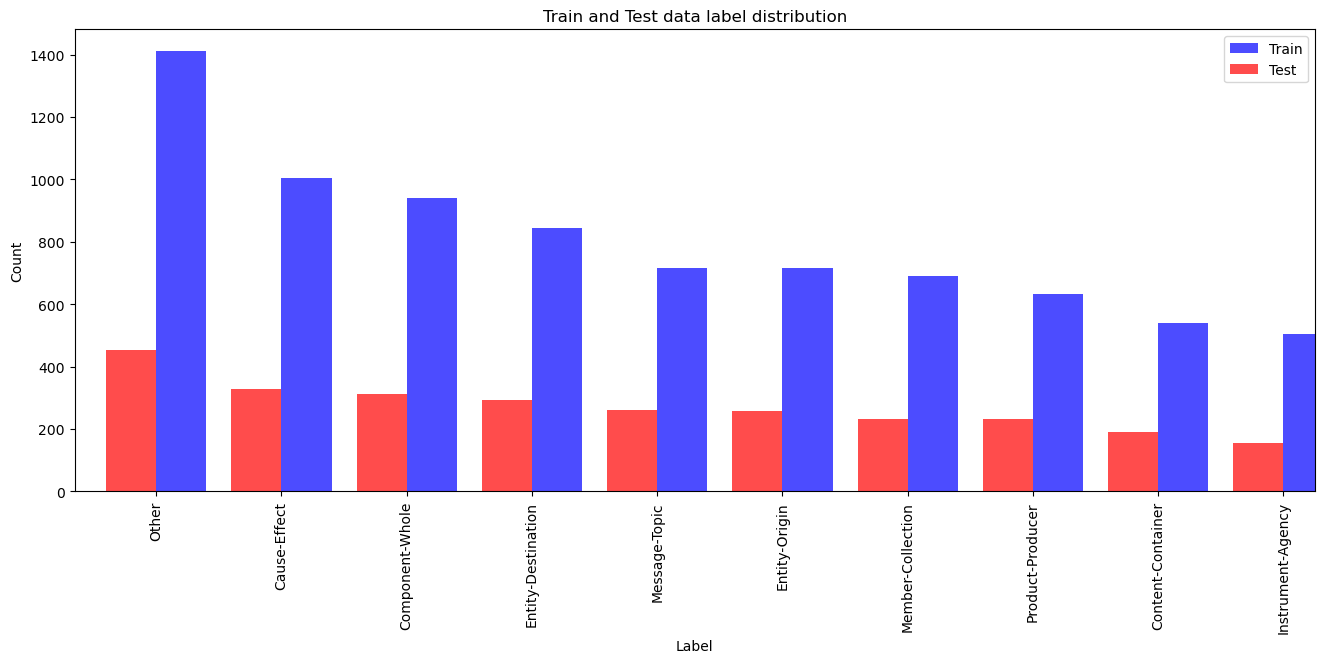

In [11]:
# plot the label distribution in each dataset

# function to plot the distribution of labels in each dataset
def plot_label_distribution(train_data, test_data, title):
    # make a copy of the data so we won't change the original dataframe
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()

    # create a figure and axis object
    fig, ax = plt.subplots(figsize=(16, 6))
    # plot the count of each label in the train and test dataset
    train_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='blue', alpha=0.7, label='Train', position=0, width=0.4)
    test_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='red', alpha=0.7, label='Test', position=1, width=0.4)

    # set the x and y axis labels and title
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(title)
    # plot the legend and show the plot
    ax.legend() 
    plt.show()
    # return the unique labels in the train
    return train_data_copy['label'].unique()
    
# call the function to plot the label distribution in the train and test datasets
train_labels = plot_label_distribution(train_df, test_df, 'Train and Test data label distribution')


<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [13]:
def prepare_data(data, tokenizer):
    data_sequences = [(tokenizer.encode(sentence), label2id[label]) for sentence, label in data]
    return data_sequences

train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

train_sequences_df = pd.DataFrame(train_sequences, columns=['tokens', 'label_id'])
test_sequences_df = pd.DataFrame(test_sequences, columns=['tokens', 'label_id'])

In [14]:
# print some examples
print('Train examples:')
display(train_sequences_df.sample(5))
print('Test examples:')
display(test_sequences_df.sample(5))

Train examples:


,tokens,label_id
7665,"[101, 5728, 1010, 27244, 2000, 1037, 3347, 200...",9
6546,"[101, 2002, 2018, 4716, 2026, 2121, 1005, 1055...",1
604,"[101, 8422, 1026, 1041, 2487, 1028, 6950, 1026...",2
712,"[101, 2023, 1026, 1041, 2487, 1028, 28458, 102...",7
1333,"[101, 2019, 13294, 1026, 1041, 2487, 1028, 216...",5


Test examples:


,tokens,label_id
1916,"[101, 1996, 6743, 2003, 2641, 2426, 1996, 1026...",8
1046,"[101, 20996, 13871, 2063, 15848, 2008, 3383, 1...",8
1913,"[101, 2009, 2003, 26096, 2053, 2625, 10021, 20...",6
692,"[101, 1996, 1026, 1041, 2487, 1028, 6823, 1452...",6
1091,"[101, 1999, 2051, 2057, 2179, 2008, 2216, 2039...",9


In [15]:
# Convert the data to PyTorch DataLoader objects
train_dataset = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the train_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the train_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(train_sequences_df['label_id'].tolist())
)

test_dataset = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the test_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the test_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(test_sequences_df['label_id'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = data_utils.random_split(train_dataset, [train_size, val_size])

# create the dataloaders
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = data_utils.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [16]:
# test the dataloaders
for batch in train_dataloader:
    input_ids, labels = batch
    print('Input IDs shape:', input_ids.shape)
    print('Labels shape:', labels.shape)
    break


Input IDs shape: torch.Size([16, 141])
Labels shape: torch.Size([16])


<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [17]:
model_part3 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(id2label)).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
# # print model layers
# print('Model layers:')
# for name, param in model_part3.named_parameters():
#     print(f'{name} has shape {param.shape}')


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [19]:
# better version of get_top_layer_parameters
def get_layer_parameters(named_params, layer_names):
    layer_params = [param for name, param in named_params if any(layer_name in name for layer_name in layer_names)]
    return layer_params

layer_names = ['classifier', 'pooler', 'layer.11']
all_model_params = model_part3.named_parameters()
top_layer_params = get_layer_parameters(all_model_params, layer_names)


In [20]:
# set requires_grad to False for all parameters except the top layer
for name, param in model_part3.named_parameters():
    param.requires_grad = False

for param in top_layer_params:
    param.requires_grad = True

print('Parameters that will be updated:') 
for name, param in model_part3.named_parameters():
    if param.requires_grad:
        print(name)

Parameters that will be updated:
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight
classifier.bias


Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [21]:
optimizer = torch.optim.Adam(top_layer_params, lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [22]:
# train the model for 1 epoch, return the average loss and accuracy
def single_train_part4(model, optimizer, criterion, train_dataloader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        sentences, labels = batch
        sentences = sentences.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model.forward(sentences)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs.logits, dim=1)
        acc = torch.sum(preds == labels).item()
        train_loss += loss.item()
        train_acc += acc
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader.dataset)
    return train_loss, train_acc

# evaluate the model on the dev set, return the average loss and accuracy
def evaluate_part4(model, criterion, dev_dataloader):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for batch in dev_dataloader:
            sentences, labels = batch
            sentences = sentences.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model.forward(sentences)
            loss = criterion(outputs.logits, labels)
            _, preds = torch.max(outputs.logits, dim=1)
            acc = torch.sum(preds == labels).item()
            val_loss += loss.item()
            val_acc += acc
    val_loss = val_loss / len(dev_dataloader)
    val_acc = val_acc / len(dev_dataloader.dataset)
    return val_loss, val_acc

# train the model for n_epochs, return the history of train loss, val loss, train acc, val acc
def full_train_part4(model, n_epochs, train_dataloader, dev_dataloader, optimizer, criterion):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = single_train_part4(model, optimizer, criterion, train_dataloader)
        val_loss, val_acc = evaluate_part4(model, criterion, dev_dataloader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(
            epoch + 1, n_epochs, train_loss, val_loss, train_acc, val_acc))
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [23]:
# train the model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = full_train_part4(model_part3, 20, train_dataloader, val_dataloader, optimizer, loss_fn)

# save the model, train and validation history
torch.save(model_part3.state_dict(), 'model_part_4.pth')
torch.save({
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history
}, 'model_part_4_history.pth')


  5%|▌         | 1/20 [00:43<13:38, 43.08s/it]

Epoch: 1/20, Train Loss: 1.6699, Val Loss: 0.8606, Train Acc: 0.3975, Val Acc: 0.7113


 10%|█         | 2/20 [01:24<12:37, 42.08s/it]

Epoch: 2/20, Train Loss: 0.8363, Val Loss: 0.8676, Train Acc: 0.7050, Val Acc: 0.7163


 15%|█▌        | 3/20 [02:06<11:53, 41.97s/it]

Epoch: 3/20, Train Loss: 0.7003, Val Loss: 0.7151, Train Acc: 0.7498, Val Acc: 0.7494


 20%|██        | 4/20 [02:48<11:12, 42.00s/it]

Epoch: 4/20, Train Loss: 0.6289, Val Loss: 0.7377, Train Acc: 0.7762, Val Acc: 0.7562


 25%|██▌       | 5/20 [03:30<10:30, 42.04s/it]

Epoch: 5/20, Train Loss: 0.5585, Val Loss: 0.7064, Train Acc: 0.7970, Val Acc: 0.7500


 30%|███       | 6/20 [04:12<09:49, 42.08s/it]

Epoch: 6/20, Train Loss: 0.5066, Val Loss: 0.7115, Train Acc: 0.8195, Val Acc: 0.7569


 35%|███▌      | 7/20 [04:54<09:07, 42.14s/it]

Epoch: 7/20, Train Loss: 0.4536, Val Loss: 0.7283, Train Acc: 0.8392, Val Acc: 0.7731


 40%|████      | 8/20 [05:37<08:26, 42.18s/it]

Epoch: 8/20, Train Loss: 0.3916, Val Loss: 0.7989, Train Acc: 0.8598, Val Acc: 0.7600


 45%|████▌     | 9/20 [06:19<07:44, 42.23s/it]

Epoch: 9/20, Train Loss: 0.3460, Val Loss: 0.7979, Train Acc: 0.8747, Val Acc: 0.7569


 50%|█████     | 10/20 [07:01<07:02, 42.28s/it]

Epoch: 10/20, Train Loss: 0.3126, Val Loss: 0.8556, Train Acc: 0.8870, Val Acc: 0.7588


 55%|█████▌    | 11/20 [07:44<06:21, 42.35s/it]

Epoch: 11/20, Train Loss: 0.2632, Val Loss: 0.8734, Train Acc: 0.9059, Val Acc: 0.7606


 60%|██████    | 12/20 [08:26<05:38, 42.36s/it]

Epoch: 12/20, Train Loss: 0.2265, Val Loss: 0.8911, Train Acc: 0.9192, Val Acc: 0.7619


 65%|██████▌   | 13/20 [09:08<04:56, 42.30s/it]

Epoch: 13/20, Train Loss: 0.2219, Val Loss: 0.9988, Train Acc: 0.9230, Val Acc: 0.7544


 70%|███████   | 14/20 [09:51<04:13, 42.24s/it]

Epoch: 14/20, Train Loss: 0.1975, Val Loss: 0.9661, Train Acc: 0.9303, Val Acc: 0.7669


 75%|███████▌  | 15/20 [10:33<03:30, 42.19s/it]

Epoch: 15/20, Train Loss: 0.1852, Val Loss: 1.0251, Train Acc: 0.9344, Val Acc: 0.7581


 80%|████████  | 16/20 [11:15<02:48, 42.14s/it]

Epoch: 16/20, Train Loss: 0.1567, Val Loss: 1.0353, Train Acc: 0.9439, Val Acc: 0.7556


 85%|████████▌ | 17/20 [11:57<02:06, 42.11s/it]

Epoch: 17/20, Train Loss: 0.1448, Val Loss: 0.9690, Train Acc: 0.9505, Val Acc: 0.7594


 90%|█████████ | 18/20 [12:39<01:24, 42.08s/it]

Epoch: 18/20, Train Loss: 0.1478, Val Loss: 1.1269, Train Acc: 0.9498, Val Acc: 0.7544


 95%|█████████▌| 19/20 [13:21<00:42, 42.07s/it]

Epoch: 19/20, Train Loss: 0.1277, Val Loss: 1.0796, Train Acc: 0.9539, Val Acc: 0.7512


100%|██████████| 20/20 [14:03<00:00, 42.16s/it]

Epoch: 20/20, Train Loss: 0.1288, Val Loss: 1.1275, Train Acc: 0.9548, Val Acc: 0.7619


In [24]:
# load the model
model_part3.load_state_dict(torch.load('model_part_4.pth'))
# load the train and validation history
checkpoint = torch.load('model_part_4_history.pth')
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
train_acc_history = checkpoint['train_acc_history']
val_acc_history = checkpoint['val_acc_history']

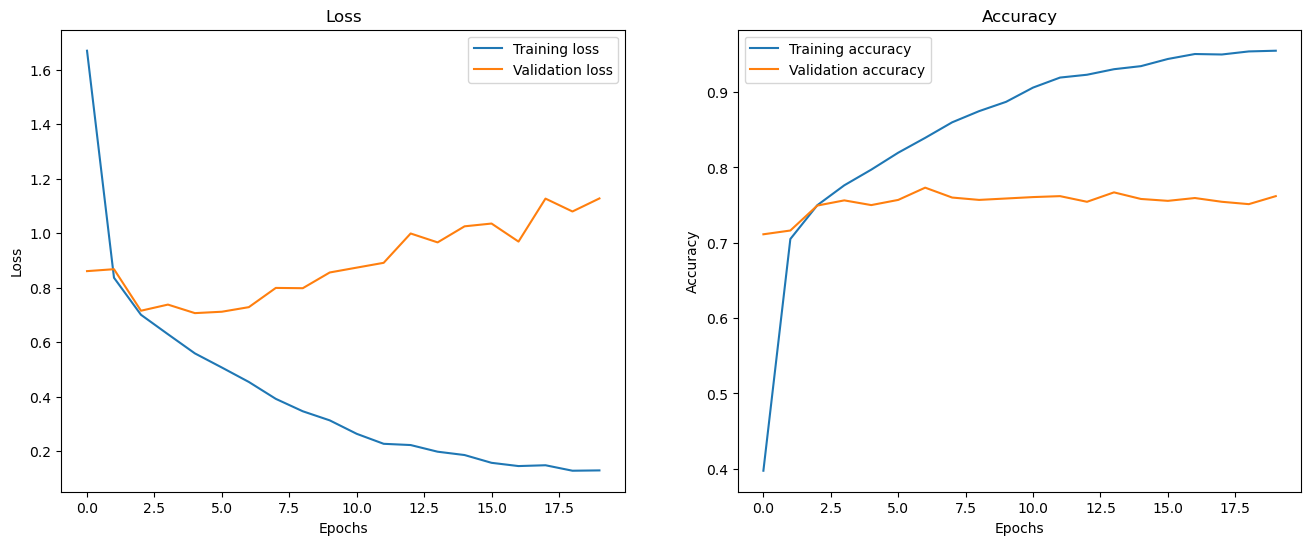

In [25]:
import matplotlib.pyplot as plt

# plot the training and validation loss
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(train_loss_history, label='Training loss')
axs[0].plot(val_loss_history, label='Validation loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot the training and validation accuracy
axs[1].plot(train_acc_history, label='Training accuracy')
axs[1].plot(val_acc_history, label='Validation accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()



<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# given model and test data, return Report (Persicion, Recall, F1, Support) and Confusion Matrix
def predict_dataloader(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in test_dataloader:
      sentences, labels = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model(sentences)
      _, preds = torch.max(outputs.logits, dim=1)
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   


# evaluate the model on the test data
y_pred , y_true = predict_dataloader(model_part3, test_dataloader)


In [27]:
def get_report(y_pred, y_true, labels):
  report = classification_report(y_true, y_pred, output_dict=True, labels=labels)
  report = pd.DataFrame(report).transpose()
  report = report.loc[labels][['precision', 'recall', 'f1-score']]
  return report

def get_cm_matrix(y_pred, y_true, labels):
  matrix = confusion_matrix(y_true, y_pred, labels=labels)
  matrix = pd.DataFrame(matrix, index=labels, columns=labels).transpose() # rows are predicted, columns are actual
  return matrix

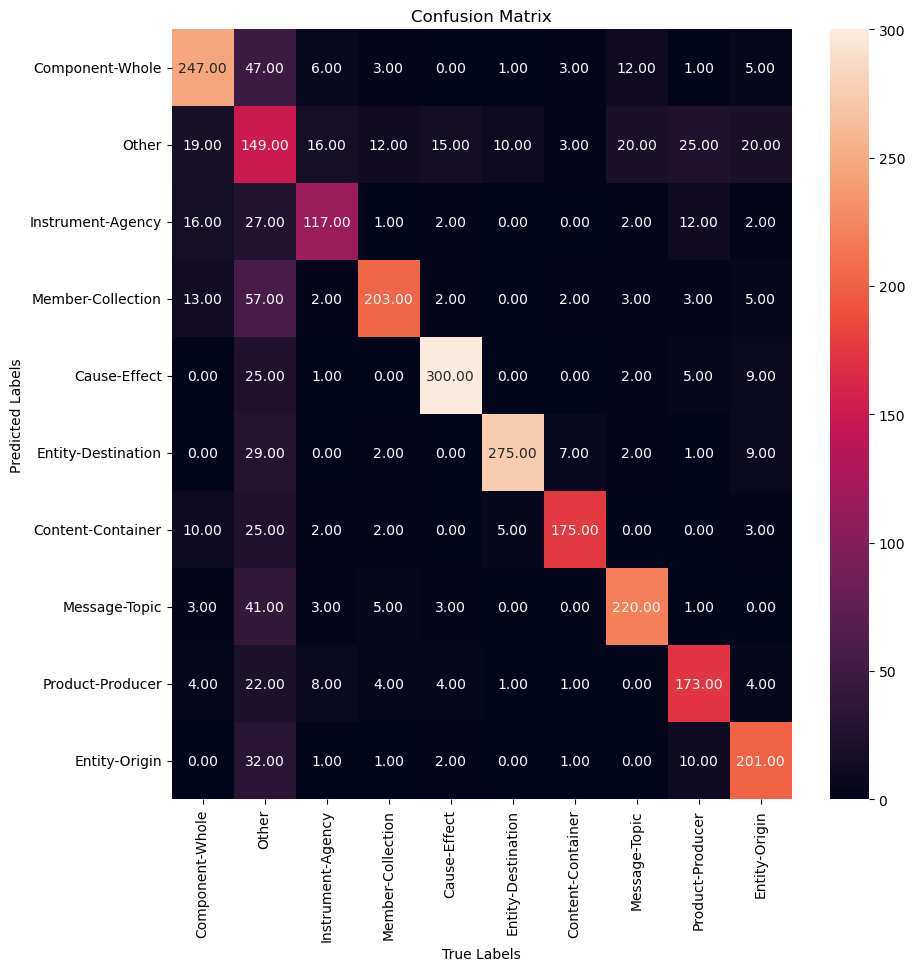

+--------------------+-------------+----------+------------+
|                    |   precision |   recall |   f1-score |
|--------------------+-------------+----------+------------|
| Component-Whole    |    0.76     | 0.791667 |   0.77551  |
| Other              |    0.515571 | 0.328194 |   0.401077 |
| Instrument-Agency  |    0.653631 | 0.75     |   0.698507 |
| Member-Collection  |    0.7      | 0.871245 |   0.776291 |
| Cause-Effect       |    0.877193 | 0.914634 |   0.895522 |
| Entity-Destination |    0.846154 | 0.941781 |   0.89141  |
| Content-Container  |    0.788288 | 0.911458 |   0.845411 |
| Message-Topic      |    0.797101 | 0.842912 |   0.819367 |
| Product-Producer   |    0.782805 | 0.748918 |   0.765487 |
| Entity-Origin      |    0.810484 | 0.77907  |   0.794466 |
+--------------------+-------------+----------+------------+


In [28]:
# convert the label_ids to labels_str
y_pred_str = [id2label[i] for i in y_pred]
y_true_str = [id2label[i] for i in y_true]

# compute confusion matrix
cm_matrix = get_cm_matrix(y_pred_str, y_true_str, list(label2id.keys()))
# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_matrix, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

# compute classification report
report = get_report(y_pred_str, y_true_str, list(label2id.keys()))
print(tabulate(report, headers='keys', tablefmt='psql'))


In [29]:
# compute the accuracy
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print('test accuracy: ', accuracy)

test accuracy:  0.7581891792418108


In [30]:
# save the report
name_to_save = student1_id + '_' + student2_id + '_part5.csv'
report.to_csv(name_to_save)

<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

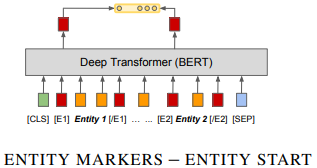

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [31]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

# add the new tokens to the tokenizer
new_tokens = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mtb_tokenizer.add_tokens(new_tokens)

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [32]:
# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"

# Read the data (tuple of (sentence, label)
train_with_entity_markers = read_data(train_filepath, remove_e1_e2_from_label=True)
test_with_entity_markers = read_data(test_filepath, remove_e1_e2_from_label=True)

# Convert to pandas dataframe
train_df_with_entity_markers = pd.DataFrame(train_with_entity_markers, columns=['sentence', 'label'])
test_df_with_entity_markers = pd.DataFrame(test_with_entity_markers, columns=['sentence', 'label'])

print('Number of train sentences:', len(train_with_entity_markers))
print('Number of test sentences:', len(test_with_entity_markers))

Number of train sentences: 8000
Number of test sentences: 2717


In [33]:
id2label_with_entity_markers, label2id_with_entity_markers = create_label_mapper(train_df_with_entity_markers)
print('label2id:', label2id_with_entity_markers)
print('id2label:', id2label_with_entity_markers)

label2id: {'Component-Whole': 0, 'Other': 1, 'Instrument-Agency': 2, 'Member-Collection': 3, 'Cause-Effect': 4, 'Entity-Destination': 5, 'Content-Container': 6, 'Message-Topic': 7, 'Product-Producer': 8, 'Entity-Origin': 9}
id2label: {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}


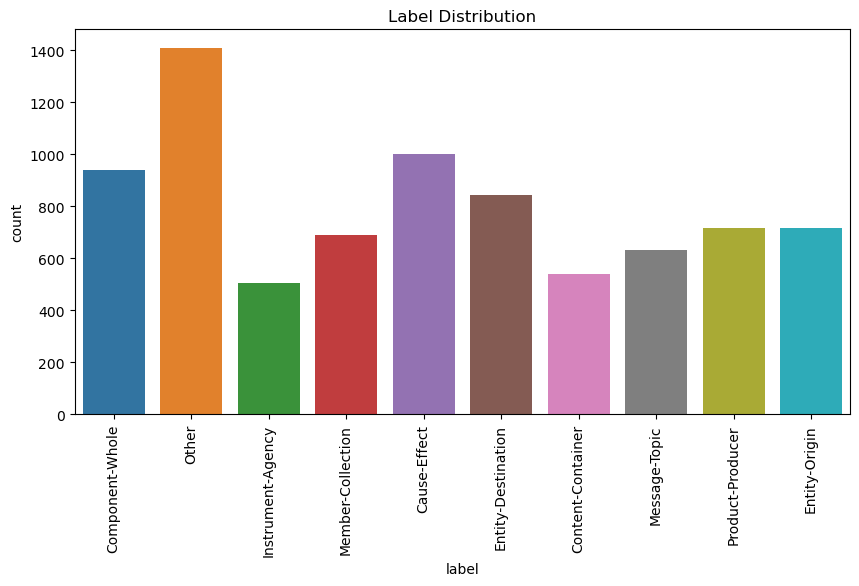

In [34]:
# plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_df_with_entity_markers)
plt.title('Label Distribution')
plt.xticks(rotation=90) # rotate x-axis labels by 90 degrees
plt.show()

In [35]:
# given a dataframe with sentence and label columns, returns a list of tuples (token_ids, label_id, index-tuple) s.t index-tuple = (e1_start, e1_end, e2_start, e2_end)
def prepare_data_MTB(data, tokenizer, batch_size=8):
    count = 0
    total = len(data)
    sequences = []
    # iterate over the data (dataframe with columns: sentence, label)
    for index, row in data.iterrows():
        sentence = row['sentence']
        label = row['label']
        # tokenize the sentence
        tokens = tokenizer.tokenize(sentence)
        # find the index of the entity markers
        if E1_START in tokens and E1_END in tokens and E2_START in tokens and E2_END in tokens:
            e1_start = tokens.index(E1_START)
            e1_end = tokens.index(E1_END)
            e2_start = tokens.index(E2_START)
            e2_end = tokens.index(E2_END)
            # convert the labels to label_ids
            label_id = label2id_with_entity_markers[label]
            # convert the tokens to token_ids
            token_ids = tokenizer.convert_tokens_to_ids(tokens)
            # add the token_ids, label_id and index-tuple to the list of sequences
            sequences.append((token_ids, label_id, (e1_start, e1_end, e2_start, e2_end)))
        else:
            count += 1
            #print('Entity markers not found in sentence:', sentence)

    print("number of sentences without entity markers:", count, "out of", total)
    return sequences

train_sequences_with_entity_markers = prepare_data_MTB(train_df_with_entity_markers, mtb_tokenizer, batch_size=16)
test_sequences_with_entity_markers = prepare_data_MTB(test_df_with_entity_markers, mtb_tokenizer, batch_size=16)

train_sequences_df_with_entity_markers = pd.DataFrame(train_sequences_with_entity_markers, columns=['tokens', 'label_id', 'index_tuple'])
test_sequences_df_with_entity_markers = pd.DataFrame(test_sequences_with_entity_markers, columns=['tokens', 'label_id', 'index_tuple'])

number of sentences without entity markers: 75 out of 8000
number of sentences without entity markers: 35 out of 2717


In [36]:
# print the first 5 rows of the train dataframe
print(train_sequences_df_with_entity_markers.head())

# print length of train and test sequences
print('Number of train sequences:', len(train_sequences_with_entity_markers))
print('Number of test sequences:', len(test_sequences_with_entity_markers))

                                              tokens  label_id   
0  [1996, 2291, 2004, 2649, 2682, 2038, 2049, 460...         0  \
1  [1996, 30522, 2775, 30523, 2001, 5362, 5058, 1...         1   
2  [1996, 30522, 3166, 30523, 1997, 1037, 3145, 6...         2   
3  [1037, 15167, 30522, 5526, 30523, 2039, 29346,...         1   
4  [1996, 30522, 3076, 30523, 30524, 2523, 30525,...         3   

        index_tuple  
0  (13, 15, 18, 20)  
1    (1, 3, 11, 13)  
2    (1, 3, 10, 16)  
3    (2, 4, 10, 12)  
4      (1, 3, 4, 6)  
Number of train sequences: 7925
Number of test sequences: 2682


In [37]:
# Create a TensorDataset object for the train data
train_dataset_with_entity_markers = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the train_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df_with_entity_markers['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the train_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(train_sequences_df_with_entity_markers['label_id'].tolist()),
    # Convert the list of tuples to a tensor
    torch.tensor(train_sequences_df_with_entity_markers['index_tuple'].tolist())
)

# Create a TensorDataset object for the test data
test_dataset_with_entity_markers = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the test_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df_with_entity_markers['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the test_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(test_sequences_df_with_entity_markers['label_id'].tolist()),
    # Convert the list of tuples to a tensor
    torch.tensor(test_sequences_df_with_entity_markers['index_tuple'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset_with_entity_markers))
val_size = len(train_dataset_with_entity_markers) - train_size
train_dataset_with_entity_markers, val_dataset_with_entity_markers = data_utils.random_split(train_dataset_with_entity_markers, [train_size, val_size])


In [38]:
# create the dataloaders
train_dataloader_with_entity_markers = data_utils.DataLoader(train_dataset_with_entity_markers, batch_size=8, shuffle=True)
val_dataloader_with_entity_markers = data_utils.DataLoader(val_dataset_with_entity_markers, batch_size=8, shuffle=True)
test_dataloader_with_entity_markers = data_utils.DataLoader(test_dataset_with_entity_markers, batch_size=8, shuffle=False)


In [39]:
# test the dataloaders
for batch in train_dataloader_with_entity_markers:
    token_ids, label_ids, index_tuples = batch
    print('token_ids shape:', token_ids.shape)
    print('label_ids shape:', label_ids.shape)
    print('index_tuples shape:', index_tuples.shape)
    break
    


token_ids shape: torch.Size([8, 125])
label_ids shape: torch.Size([8])
index_tuples shape: torch.Size([8, 4])


In [40]:
# Print the number of batches in the train, validation, and test DataLoader objects
print(f"Number of batches in train DataLoader: {len(train_dataloader_with_entity_markers)}")
print(f"Number of batches in validation DataLoader: {len(val_dataloader_with_entity_markers)}")
print(f"Number of batches in test DataLoader: {len(test_dataloader_with_entity_markers)}")

# print total number of samples in train, validation and test dataloaders
print('Number of samples in train dataloader:', len(train_dataloader_with_entity_markers.dataset))
print('Number of samples in validation dataloader:', len(val_dataloader_with_entity_markers.dataset))
print('Number of samples in test dataloader:', len(test_dataloader_with_entity_markers.dataset))


Number of batches in train DataLoader: 793
Number of batches in validation DataLoader: 199
Number of batches in test DataLoader: 336
Number of samples in train dataloader: 6340
Number of samples in validation dataloader: 1585
Number of samples in test dataloader: 2682


Create a new model that uses the "entity markers - Entity start" method.

Use the new dataloader and model to train the new model as in task 4.



In [41]:
class MTB(nn.Module):
    def __init__(self, base_model, num_labels):
        super(MTB, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(self.base_model.config.hidden_size * 2, num_labels)

        # freeze all layer of base model except the classifier,pooler and 11th layer
        for name, param in self.base_model.named_parameters():
            if 'classifier' not in name and 'pooler' not in name and 'layer.11' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def forward(self, token_ids, index_tuples):
        # get the last hidden states from the base model
        outputs = self.base_model.forward(token_ids)
        last_hidden_states = outputs[0]

        # get the indices of the entity markers
        index_tuples_E1 = index_tuples[:,0]
        index_tuples_E2 = index_tuples[:,2]

        # get the representations of the entities
        E1_rep = last_hidden_states[torch.arange(len(index_tuples)), index_tuples_E1]
        E2_rep = last_hidden_states[torch.arange(len(index_tuples)), index_tuples_E2]

        # concatenate the representations of the entities
        E1_E2_rep = torch.cat([E1_rep, E2_rep], dim=1)

        # pass the concatenated representations through the classifier
        logits = self.classifier(E1_E2_rep)

        return logits


In [42]:
base_model_MTB = AutoModel.from_pretrained('bert-base-uncased')
base_model_MTB.resize_token_embeddings(len(mtb_tokenizer))

# Create a new model using the "entity markers - Entity start" method
model_MTB = MTB(base_model_MTB, len(id2label_with_entity_markers.keys()))


# Move the model to the device
model_MTB.to(DEVICE)

model_params = model_MTB.named_parameters()
last_layer_params = [param for name, param in model_params if 'classifier' in name or 'pooler' in name or 'layer.11' in name]

# Define the optimizer
optimizer = torch.optim.Adam(last_layer_params, lr=0.0001)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# evaluate the given model on the given dataloader
def evaluate_MTB(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the loss and accuracy variables
    loss = 0.0
    acc = 0.0
    total_predictions = 0
    # Iterate over the dataloader
    for batch in dataloader:
        with torch.no_grad():
            # Get the token ids, label ids, and index tuples from the batch
            token_ids, label_ids, index_tuples = batch
            # Move the tensors to the configured device
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            index_tuples = index_tuples.to(device)
            # Pass the token ids and index tuples to the model
            logits = model(token_ids, index_tuples).to(device)
            # Calculate the loss for the batch
            loss += loss_fn(logits, label_ids).item()
            # Calculate the predictions
            predictions = torch.argmax(logits, dim=-1)
            # Update correct predictions
            acc += torch.sum((predictions == label_ids)).item()
            # Update total predictions
            total_predictions += len(label_ids)
    # Calculate the average loss and accuracy
    loss = loss/len(dataloader)
    acc = acc/total_predictions
    # Return the loss and accuracy
    return loss, acc

# train the given model on the given dataloader for one epoch
def single_train_MTB(model, dataloader, optimizer, loss_fn, device):
    # Set the model to training mode
    model.train()
    # Initialize the loss and accuracy variables
    total_loss = 0.0
    acc = 0.0
    total_predictions = 0
    # Iterate over the dataloader
    for batch in dataloader:
        # Clear the gradients
        model.zero_grad()
        # Get the token ids, label ids, and index tuples from the batch
        token_ids, label_ids, index_tuples = batch
        # Move the tensors to the configured device
        token_ids = token_ids.to(device)
        label_ids = label_ids.to(device)
        index_tuples = index_tuples.to(device)
        # Pass the token ids and index tuples to the model
        logits = model.forward(token_ids, index_tuples)
        # Calculate the loss for the batch
        loss = loss_fn(logits, label_ids)
        # Update the total loss variable
        total_loss += loss.item()
        # Calculate the predictions
        predictions = torch.argmax(logits, dim=-1)
        # Update correct predictions
        acc += torch.sum((predictions == label_ids)).item()
        # Update total predictions
        total_predictions += len(label_ids)
        # Calculate the gradients for the batch
        loss.backward()
        # Update the optimizer parameters
        optimizer.step()
    # Calculate the average loss and accuracy
    avg_loss = total_loss/len(dataloader)
    acc = acc/total_predictions
    # Return the average loss and accuracy
    return avg_loss, acc

# train and evaluate the given model on the given dataloaders for the given number of epochs
def full_train_MTB(model, train_dataloader, val_dataloader, epochs, optimizer, loss_fn, device):
    # Set the model to training mode
    model.train()
    # history variables
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    # Start the training loop
    for epoch in tqdm(range(epochs)):
        # Print epoch
        print(f'Starting epoch {epoch+1}')
        # Train the model for one epoch
        train_loss, train_acc = single_train_MTB(model, train_dataloader, optimizer, loss_fn, device)
        # Evaluate the model on the validation data
        val_loss, val_acc = evaluate_MTB(model, val_dataloader, loss_fn, device)
        # Append the loss and accuracy to the respective lists
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        # Print the metrics for the validation data
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, train loss: {train_loss}, train acc: {train_acc}')
    # Return the loss and accuracy histories
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [44]:
history_MTB = full_train_MTB(model_MTB, train_dataloader_with_entity_markers, val_dataloader_with_entity_markers, 20, optimizer, loss_fn, DEVICE)
train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB = history_MTB
# Save the model
torch.save(model_MTB.state_dict(), 'MTB_model.pth')
# save the history
with open('MTB_history.pkl', 'wb') as f:
    pickle.dump([train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB], f)

  0%|          | 0/20 [00:00<?, ?it/s]

Starting epoch 1


  5%|▌         | 1/20 [00:42<13:22, 42.22s/it]

Validation Loss: 0.8973827474380858, Validation Accuracy: 0.6839116719242903, train loss: 1.3718647535556803, train acc: 0.5190851735015772
Starting epoch 2


 10%|█         | 2/20 [01:24<12:36, 42.03s/it]

Validation Loss: 0.8288849297882849, Validation Accuracy: 0.7154574132492113, train loss: 0.8911903978784629, train acc: 0.6818611987381703
Starting epoch 3


 15%|█▌        | 3/20 [02:05<11:52, 41.94s/it]

Validation Loss: 0.8164702580502284, Validation Accuracy: 0.7249211356466877, train loss: 0.7719776057186073, train acc: 0.723186119873817
Starting epoch 4


 20%|██        | 4/20 [02:47<11:08, 41.80s/it]

Validation Loss: 0.7805862730911853, Validation Accuracy: 0.7205047318611988, train loss: 0.6906275041918135, train acc: 0.7586750788643533
Starting epoch 5


 25%|██▌       | 5/20 [03:29<10:26, 41.77s/it]

Validation Loss: 0.8537360867251403, Validation Accuracy: 0.7154574132492113, train loss: 0.6201288524597018, train acc: 0.7798107255520504
Starting epoch 6


 30%|███       | 6/20 [04:11<09:45, 41.81s/it]

Validation Loss: 0.7689027478965234, Validation Accuracy: 0.7413249211356467, train loss: 0.5672893933763946, train acc: 0.7985804416403786
Starting epoch 7


 35%|███▌      | 7/20 [04:52<09:03, 41.81s/it]

Validation Loss: 0.7936751431406442, Validation Accuracy: 0.7526813880126183, train loss: 0.5132370092336459, train acc: 0.8151419558359622
Starting epoch 8


 40%|████      | 8/20 [05:34<08:21, 41.77s/it]

Validation Loss: 0.7684840916482797, Validation Accuracy: 0.7539432176656151, train loss: 0.44826735825539765, train acc: 0.8421135646687697
Starting epoch 9


 45%|████▌     | 9/20 [06:16<07:39, 41.79s/it]

Validation Loss: 0.7939197415457898, Validation Accuracy: 0.7570977917981072, train loss: 0.40916509729954514, train acc: 0.8569400630914826
Starting epoch 10


 50%|█████     | 10/20 [06:58<06:57, 41.78s/it]

Validation Loss: 0.8377937623089058, Validation Accuracy: 0.7451104100946372, train loss: 0.36632925936949884, train acc: 0.8684542586750789
Starting epoch 11


 55%|█████▌    | 11/20 [07:40<06:16, 41.85s/it]

Validation Loss: 0.8101878352650446, Validation Accuracy: 0.7570977917981072, train loss: 0.3449349499297003, train acc: 0.87397476340694
Starting epoch 12


 60%|██████    | 12/20 [08:21<05:34, 41.79s/it]

Validation Loss: 0.8909171376255663, Validation Accuracy: 0.7552050473186119, train loss: 0.30304872206897293, train acc: 0.8958990536277602
Starting epoch 13


 65%|██████▌   | 13/20 [09:03<04:53, 41.88s/it]

Validation Loss: 0.9557165254712404, Validation Accuracy: 0.7400630914826498, train loss: 0.27921314947107456, train acc: 0.9011041009463723
Starting epoch 14


 70%|███████   | 14/20 [09:46<04:11, 41.97s/it]

Validation Loss: 0.8837814309292628, Validation Accuracy: 0.7564668769716089, train loss: 0.2599242664092604, train acc: 0.9094637223974763
Starting epoch 15


 75%|███████▌  | 15/20 [10:28<03:29, 41.97s/it]

Validation Loss: 0.9269214835125121, Validation Accuracy: 0.7570977917981072, train loss: 0.24700598008220154, train acc: 0.91198738170347
Starting epoch 16


 80%|████████  | 16/20 [11:10<02:48, 42.05s/it]

Validation Loss: 0.978181585847358, Validation Accuracy: 0.7457413249211357, train loss: 0.2277569346987815, train acc: 0.9194006309148265
Starting epoch 17


 85%|████████▌ | 17/20 [11:52<02:06, 42.07s/it]

Validation Loss: 0.9695364963731274, Validation Accuracy: 0.7287066246056783, train loss: 0.21381516551671134, train acc: 0.9290220820189274
Starting epoch 18


 90%|█████████ | 18/20 [12:34<01:24, 42.06s/it]

Validation Loss: 1.0045705600571468, Validation Accuracy: 0.7425867507886436, train loss: 0.198858937424018, train acc: 0.9298107255520505
Starting epoch 19


 95%|█████████▌| 19/20 [13:16<00:42, 42.07s/it]

Validation Loss: 1.0517901412115418, Validation Accuracy: 0.7539432176656151, train loss: 0.1864687680774151, train acc: 0.9367507886435331
Starting epoch 20


100%|██████████| 20/20 [13:58<00:00, 41.93s/it]

Validation Loss: 1.0721936112008847, Validation Accuracy: 0.7287066246056783, train loss: 0.17772556017823124, train acc: 0.9433753943217665


In [45]:
# load the model
model_MTB.load_state_dict(torch.load('MTB_model.pth'))
# load the history
with open('MTB_history.pkl', 'rb') as f:
    train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB = pickle.load(f)
    

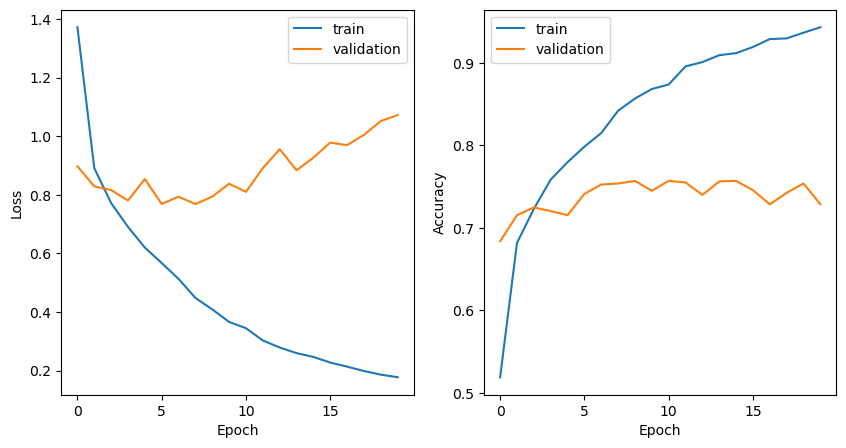

In [46]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_MTB, label='train')
plt.plot(val_loss_history_MTB, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_MTB, label='train')
plt.plot(val_acc_history_MTB, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [47]:
def predict_MTB(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in test_dataloader:
      sentences, labels, index_tuples = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model.forward(sentences, index_tuples)
      _, preds = torch.max(outputs, dim=1)
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   

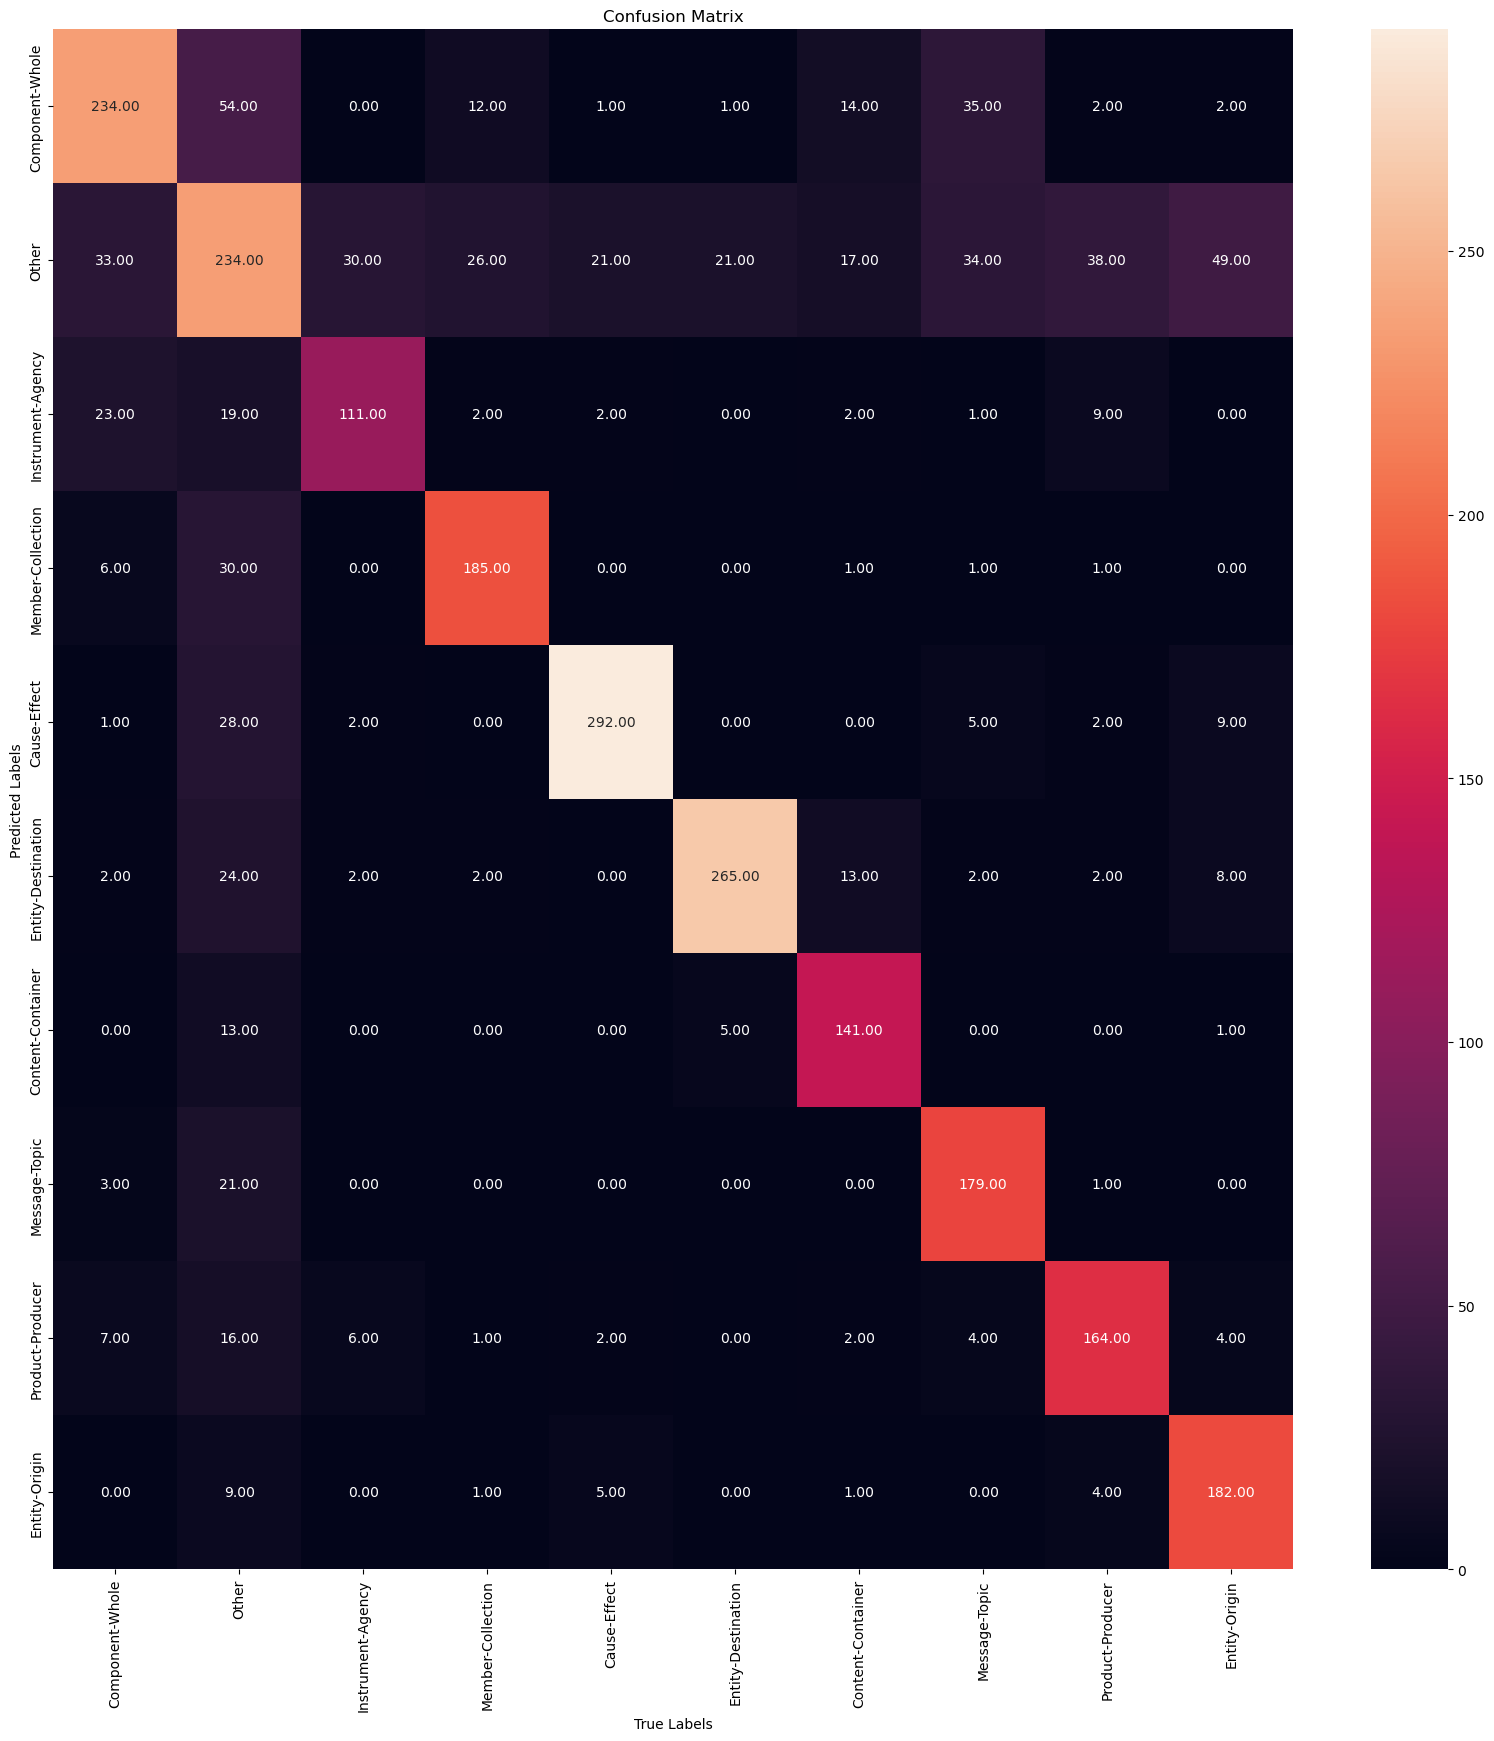

+--------------------+-------------+----------+------------+
|                    |   precision |   recall |   f1-score |
|--------------------+-------------+----------+------------|
| Component-Whole    |    0.659155 | 0.757282 |   0.704819 |
| Other              |    0.465209 | 0.522321 |   0.492114 |
| Instrument-Agency  |    0.656805 | 0.735099 |   0.69375  |
| Member-Collection  |    0.825893 | 0.80786  |   0.816777 |
| Cause-Effect       |    0.861357 | 0.904025 |   0.882175 |
| Entity-Destination |    0.828125 | 0.907534 |   0.866013 |
| Content-Container  |    0.88125  | 0.73822  |   0.803419 |
| Message-Topic      |    0.877451 | 0.685824 |   0.769892 |
| Product-Producer   |    0.796117 | 0.735426 |   0.764569 |
| Entity-Origin      |    0.90099  | 0.713725 |   0.796499 |
+--------------------+-------------+----------+------------+


In [48]:
y_pred_MTB, y_true_MTB = predict_MTB(model_MTB, test_dataloader_with_entity_markers)

# convert the label ids to labels
y_pred_str_MTB = [id2label_with_entity_markers[id] for id in y_pred_MTB]
y_true_str_MTB = [id2label_with_entity_markers[id] for id in y_true_MTB]

report_MTB = get_report(y_pred_str_MTB, y_true_str_MTB, list(label2id_with_entity_markers.keys()))
cm_MTB = get_cm_matrix(y_pred_str_MTB, y_true_str_MTB, list(label2id_with_entity_markers.keys()))

# plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm_MTB, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

print(tabulate(report_MTB, headers='keys', tablefmt='psql'))

# display()
# save()

In [49]:
# compute the accuracy
accuracy_MTB = np.sum(np.array(y_true_MTB) == np.array(y_pred_MTB)) / len(y_true_MTB)
print('test accuracy: ', accuracy_MTB)


test accuracy:  0.7408650260999254


In [50]:
# save report in csv
name_to_save = student1_id + '_' + student2_id + '_part6.csv'
report_MTB.to_csv(name_to_save)

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [51]:
# clear GPU space
torch.cuda.empty_cache()

Set all the relavant random seed to 111

In [52]:
# set all random seeds to 111
SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [53]:
# load the train dataset
train_data_part7 = pd.read_csv('nlp_2023_train.csv')
# remove the columns that are not needed ('Unnamed: 0')
train_data_part7 = train_data_part7.drop(columns=['Unnamed: 0'])
# print head
train_data_part7.head()


,text1,text2,Similarity
0,How many customers does Apple have?,How many servers does apple have?,0.0
1,Pregnancy k stating month m kya Khana chaiye?,Do those who want heaven most do the most for ...,0.0
2,What changes are there in MHRD scholarship giv...,On what criteria are the scholarships given to...,0.0
3,What are some best book for Computer Architect...,Which writer should I follow for computer arch...,0.0
4,What are some unexpected things first-time vis...,What are some unexpected things first-time vis...,0.0


Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [54]:
model_part7 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(DEVICE)

# test the encoder
sentences = ["This is an example sentence", "Each sentence is converted"]
embeddings = model_part7.encode(sentences)
print('sentence before embedding: ', sentences)
print('sentence after embedding: ', embeddings)




sentence before embedding:  ['This is an example sentence', 'Each sentence is converted']
sentence after embedding:  [[ 0.02250262 -0.07829171 -0.02303072 ... -0.00827928  0.02652687
  -0.00201896]
 [ 0.04170236  0.00109743 -0.01553419 ... -0.02181627 -0.06359358
  -0.00875288]]


Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

Index(['text1', 'text2', 'Similarity'], dtype='object')


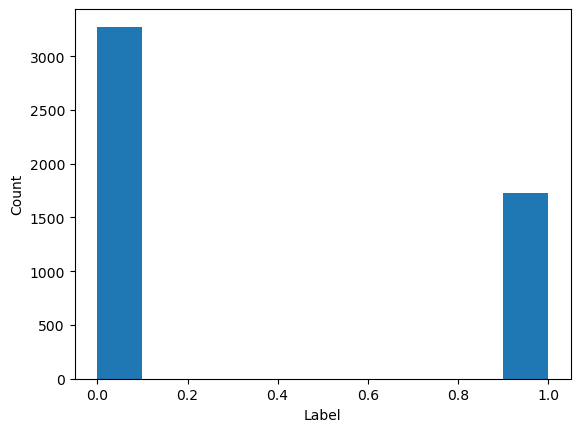

In [61]:
# limit to first 5k lines
train_data_part7 = train_data_part7.head(5000)

# print column names
print(train_data_part7.columns)

# print head
train_data_part7.head()

# plot label distribution
true_labels_part7 = np.array(train_data_part7['Similarity'].tolist(), dtype=int)
plt.hist(true_labels_part7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [56]:
# get the embeddings for both sentences
text1_embeddings = model_part7.encode(train_data_part7['text1'].tolist())
text2_embeddings = model_part7.encode(train_data_part7['text2'].tolist())


In [57]:
# calculate the cosine similarity between the sentence embeddings
similarities = [1 - cosine(embedding1, embedding2) for embedding1, embedding2 in zip(text1_embeddings, text2_embeddings)]

# make predictions: if similarity is more than 0.5, then similar (1), else not similar (0)
predictions_part7 = np.array([1 if similarity >= 0.5 else 0 for similarity in similarities], dtype=int)
true_labels_part7 = np.array(train_data_part7['Similarity'].tolist(), dtype=int)

# print the predictions and true labels
print('Predictions:', predictions_part7)
print('True Labels:', true_labels_part7)

# compute the accuracy
accuracy = np.sum(true_labels_part7 == predictions_part7) / len(true_labels_part7)
print('Accuracy:', accuracy)


Predictions: [1 0 1 ... 0 1 0]
True Labels: [0 0 0 ... 0 1 0]
Accuracy: 0.5932


Print a classification report (use a simple SK-learn classification report)

In [58]:
report_part7 = get_report(predictions_part7, true_labels_part7, ['0', '1'])
print(tabulate(report_part7, headers='keys', tablefmt='psql'))

+----+-------------+----------+------------+
|    |   precision |   recall |   f1-score |
|----+-------------+----------+------------|
|  0 |    0.996795 | 0.379963 |   0.550199 |
|  1 |    0.458955 | 0.997683 |   0.628697 |
+----+-------------+----------+------------+


Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [64]:
# Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`
# - Do not write the index number to the CSV file.
# - Make sure the CSV file will contain only integers.

# save the predictions to a csv file
df_part7 = pd.DataFrame({'ID': np.arange(0, len(predictions_part7)), 'LABEL_TRUE': true_labels_part7, 'LABEL_PRED': predictions_part7})
print(df_part7)
name_to_save = student1_id + '_' + student2_id + '_part7.csv'
df_part7.to_csv(name_to_save, index=False)
print('Saved predictions to', name_to_save)
print('Done!')




        ID  LABEL_TRUE  LABEL_PRED
0        0           0           1
1        1           0           0
2        2           0           1
3        3           0           1
4        4           0           1
...    ...         ...         ...
4995  4995           0           1
4996  4996           0           0
4997  4997           0           0
4998  4998           1           1
4999  4999           0           0

[5000 rows x 3 columns]
Saved predictions to 327156998_123456789_part7.csv
Done!


<br><br><br><br><br><br>
**Good luck!**